In [30]:
import sys
import os
import shutil
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from contextlib import closing
import urllib.request as request
import requests
import numpy as np
import ahocorasick
from Bio import SeqIO
import hashlib
from pyteomics import mztab

In [31]:
'''
General
'''
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = '/pride/data/proteomes/proteogenomics/pgdb-manuscript/'
#'pride/data/proteomes/proteogenomics/cell-lines'
id_dir = 'proteomics_lfq'
triqler_file_name = 'out_triqler.tsv'
mzTab_file_name = 'out.mzTab'
output_file = 'identified_peptides_mice.tsv'
contaminants = 'contaminants.fasta'
canonical_proteins_fasta = 'ref_peptide_collections_toblast_mice.fa'
peps_id_dir = 'peptide_ids'
checksums_file = 'checklist.chk'

#get all canonical sequences from fasta
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))

#get protein IDs from the contaminated database
conatm_ids = set([x.strip('>').strip('\n').split(' ')[0] for x in open(contaminants, 'r').readlines() if x.startswith('>')])

def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [32]:
#Get list of samples
try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftplib.FTP.maxline = 100000
    ftp.cwd(samples_dir)
    samples_list = [x for x in ftp.nlst() if 'PXD018891' in x or 'PXD006439' in x]
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print("Number of Samples completed: " + str(len(samples_list)))

Number of Samples completed: 16


In [33]:
checksums = {}
try:
    lines = []
    ftp.retrlines('RETR {}'.format(checksums_file), lines.append)
    for line in lines:
        checksums[line.strip().split(' ')[-1].lstrip('./')] = line.strip().split(' ')[0]
except ftplib.error_perm as e: #the search is not done yet!
    print('Failed to get checksums file: {} in {}'.format(checksums_file, ftp.pwd(), e))
print(samples_list)

['PXD006439-Sample-1', 'PXD006439-Sample-10', 'PXD006439-Sample-11', 'PXD006439-Sample-12', 'PXD006439-Sample-13', 'PXD006439-Sample-14', 'PXD006439-Sample-2', 'PXD006439-Sample-3', 'PXD006439-Sample-4', 'PXD006439-Sample-5', 'PXD006439-Sample-6', 'PXD006439-Sample-7', 'PXD006439-Sample-8', 'PXD006439-Sample-9', 'PXD018891-B16-F1', 'PXD018891-B16-F1R2']


In [34]:
#extract peptides from triqler csv files

#get all peptides from the finished samples
triqler_peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    lines = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, triqler_file_name), lines.append)
        this_peps_df = pd.DataFrame(data=[x.split('\t') for x in lines[1::]],
                          columns = lines[0].split('\t'))
        this_peps_df['Sample'] = sample
        print('Sample {}, #Peptides: {}'.format(sample, len(this_peps_df)))
    except ftplib.error_perm as e: #the search is not done yet!
        print('Sample: {}, error: {}'.format(sample, e))
        continue #to next sample
        
    triqler_peps_df = pd.concat([triqler_peps_df, this_peps_df])
    

Sample PXD006439-Sample-1, #Peptides: 85976
Sample PXD006439-Sample-10, #Peptides: 70195
Sample PXD006439-Sample-11, #Peptides: 73468
Sample PXD006439-Sample-12, #Peptides: 74410
Sample PXD006439-Sample-13, #Peptides: 74086
Sample PXD006439-Sample-14, #Peptides: 33497
Sample PXD006439-Sample-2, #Peptides: 91798
Sample PXD006439-Sample-3, #Peptides: 84760
Sample PXD006439-Sample-4, #Peptides: 72685
Sample PXD006439-Sample-5, #Peptides: 80265
Sample PXD006439-Sample-6, #Peptides: 92407
Sample PXD006439-Sample-7, #Peptides: 73548
Sample PXD006439-Sample-8, #Peptides: 77510
Sample PXD006439-Sample-9, #Peptides: 70433
Sample PXD018891-B16-F1, #Peptides: 79757
Sample PXD018891-B16-F1R2, #Peptides: 82448


In [35]:
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(triqler_peps_df), len(set(triqler_peps_df['Sample'])), len(triqler_peps_df)/len(set(triqler_peps_df.Sample))))


Extracted 1217243 peptides from 16 Samples, Avg. Peptides per Sample: 76077.6875



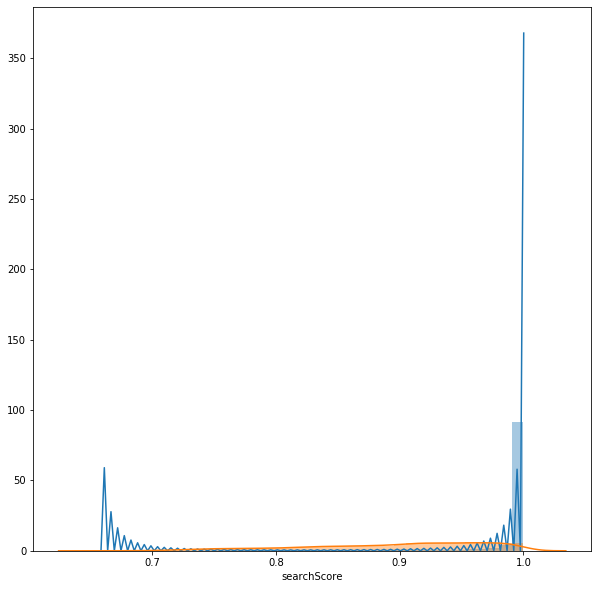

In [36]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

triqler_targets = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == False]
triqler_decoys = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(triqler_targets['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(triqler_decoys['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

In [37]:
#shorten accessions to save memory
def rep_acc(accessions):
    if 'CONTAMINANT' in accessions:
        return 'contaminant'
    
    if 'ENSMUSP' in accessions:
        return 'ENSMUSP'
    
    for acc in accessions.split(';'):
        if acc.split('_')[0] in ['altorf', 'pseudo', 'ncRNA']:
            return 'non_canonical'

    if 'var_rs' in accessions:
        return 'variant'

    if 'var_mut' in accessions:
        return 'mutation'

    return accessions

In [38]:
triqler_targets['Class'] = triqler_targets['proteins'].apply(rep_acc)

/Users/yperez/local-apps/miniconda3/envs/jupyternotebooks/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
triqler_targets.head
triqler_targets['Class'].value_counts()

ENSMUSP        1159049
contaminant      36345
variant           4630
mutation          2883
Name: Class, dtype: int64

In [40]:
print('#ENSMUSP seqs', len(set(triqler_targets[triqler_targets['Class']=='ENSMUSP']['peptide'].apply(rep).tolist())))
print('#non_canonical seqs', len(set(triqler_targets[triqler_targets['Class']=='non_canonical']['peptide'].apply(rep).tolist())))
print('#variant seqs', len(set(triqler_targets[triqler_targets['Class']=='variant']['peptide'].apply(rep).tolist())))
print('#mutation seqs', len(set(triqler_targets[triqler_targets['Class']=='mutation']['peptide'].apply(rep).tolist())))
print('#non_canonical seqs', len(set(triqler_targets[triqler_targets['Class']=='contaminant']['peptide'].apply(rep).tolist())))

#ENSMUSP seqs 105388
#non_canonical seqs 0
#variant seqs 1928
#mutation seqs 913
#non_canonical seqs 2745


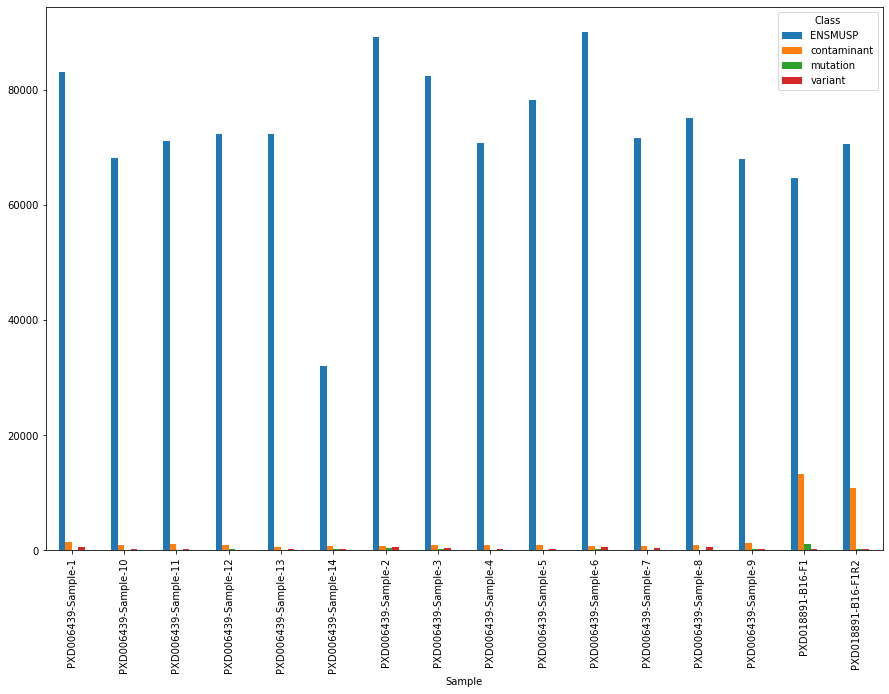

In [41]:
plt.rcParams["figure.figsize"] = [15, 10]
triqler_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [42]:
triqler_targets.to_csv('all_mice_'+triqler_file_name, sep='\t', index=False)

In [43]:
triqler_noncan_targets = triqler_targets[triqler_targets['Class'].str.contains(r"variant|non_canonical|mutation")==True]
triqler_noncan_seqs = list(set([rep(x) for x in triqler_noncan_targets['peptide'].tolist()]))

In [44]:
#get non-canonical peptides that are found in canonical proteins
triqler_found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in triqler_noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        triqler_found_peps.append(found)

In [45]:
print(len(triqler_noncan_targets))

7513


In [46]:
triqler_noncan_targets = triqler_noncan_targets[triqler_noncan_targets['peptide'].apply(rep).isin(triqler_found_peps)==False]

In [47]:
plt.rcParams["figure.figsize"] = [20, 10]
triqler_noncan_targets.groupby('Class').Sample.value_counts()


Class     Sample             
mutation  PXD018891-B16-F1       36
          PXD006439-Sample-7     29
          PXD006439-Sample-9     29
          PXD006439-Sample-13    27
          PXD006439-Sample-2     26
          PXD006439-Sample-4     26
          PXD006439-Sample-10    25
          PXD006439-Sample-8     25
          PXD006439-Sample-3     24
          PXD006439-Sample-12    22
          PXD006439-Sample-5     22
          PXD006439-Sample-11    21
          PXD018891-B16-F1R2     20
          PXD006439-Sample-6     19
          PXD006439-Sample-1     18
          PXD006439-Sample-14    14
variant   PXD018891-B16-F1R2     63
          PXD006439-Sample-1     58
          PXD006439-Sample-8     57
          PXD018891-B16-F1       55
          PXD006439-Sample-10    50
          PXD006439-Sample-9     50
          PXD006439-Sample-13    48
          PXD006439-Sample-3     47
          PXD006439-Sample-5     46
          PXD006439-Sample-6     45
          PXD006439-Sample-12    4

In [48]:
'''blastp has to be availble on the system otherwise 
   download blast executables from https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/
   '''

#write the non_canonical peptides to a fasta file
peps = set(triqler_noncan_targets['peptide'].apply(rep).tolist())
query_db = 'non_canonical_peps_mice.fa'
with open(query_db, 'w') as peps_fa:
    for pep in set(peps):
        peps_fa.write('>{}\n{}\n'.format(pep,pep))


In [49]:
makedb_cmd = "makeblastdb -in {blastdb} -dbtype prot".format(blastdb=canonical_proteins_fasta)
os.system(makedb_cmd)

0

In [50]:
runblast_cmd = """blastp \
            -db {blastdb} -query {query_db} -outfmt '6 qseqid sseqid pident qlen slen qstart qend \
            sstart send mismatch positive gapopen gaps qseq sseq evalue bitscore' \
            -num_threads {num_cores} -evalue 10000 -comp_based_stats 0 -ungapped \
            -out {blast_outfile}""".format(blastdb = canonical_proteins_fasta, num_cores = 4, 
                                           query_db=query_db, blast_outfile=query_db+'_blasted')
os.system(runblast_cmd)

0

In [51]:
def parse_blast_output(blast_out_tsv):
    
    blastout={}
    with open(blast_out_tsv, 'r') as blast_out:
        for line in blast_out.readlines():
            row=line.strip().split("\t")
            alignlen=int(row[6])-int(row[5])+1
            category="NA"
            if alignlen==int(row[3]) and float(row[2])==100:
                    blastout[row[0]] = "canonical"
            elif alignlen==int(row[3]) and float(row[2])<100:
                if int(row[12])==0 and int(row[9])==1:
                    blastout[row[0]] = "1aa_missmatch_"+row[1]
                elif int(row[12])==1 and int(row[9])==0:
                    blastout[row[0]] = "1aa_ins_"+row[1]
            elif int(row[3])-alignlen==1 and float(row[2])==100:
                blastout[row[0]] = "1aa_del_"+row[1]
            
    return blastout

In [52]:
blastout = parse_blast_output(query_db+'_blasted')

In [53]:
triqler_noncan_targets['blast_cat'] = np.where(triqler_noncan_targets.peptide.apply(rep).isin(blastout),'onemismatch', 'novel')

In [54]:
print('#PSMs per class:\n', triqler_noncan_targets['Class'].value_counts())
print('\n#unique non_can|var|mutation seqs: ', len(set(triqler_noncan_targets['peptide'].apply(rep))))
print('#unique non_can seqs: ', len(set(triqler_noncan_targets[triqler_noncan_targets['Class'] == "non_canonical"]['peptide'].apply(rep))))
print('#unique var seqs: ', len(set(triqler_noncan_targets[triqler_noncan_targets['Class'] == "variant"]['peptide'].apply(rep))))
print('#unique mutation seqs: ', len(set(triqler_noncan_targets[triqler_noncan_targets['Class'] == "mutation"]['peptide'].apply(rep))))

print('\n#unique non_can and novel seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='novel') & (triqler_noncan_targets['Class'] == "non_canonical")]['peptide'].apply(rep).tolist())))
print('#unique non_can and mismatch seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='onemismatch') & (triqler_noncan_targets['Class'] == "non_canonical")]['peptide'].apply(rep).tolist())))

print('\n#unique variant and novel seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='novel') & (triqler_noncan_targets['Class'] == "variant")]['peptide'].apply(rep).tolist())))
print('#unique variant and mismatch seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='onemismatch') & (triqler_noncan_targets['Class'] == "variant")]['peptide'].apply(rep).tolist())))

print('\n#unique mutation and novel seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='novel') & (triqler_noncan_targets['Class'] == "mutation")]['peptide'].apply(rep).tolist())))
print('#unique mutation and mismatch seqs: ', len(set(triqler_noncan_targets[ (triqler_noncan_targets['blast_cat']=='onemismatch') & (triqler_noncan_targets['Class'] == "mutation")]['peptide'].apply(rep).tolist())))

#PSMs per class:
 variant     738
mutation    383
Name: Class, dtype: int64

#unique non_can|var|mutation seqs:  540
#unique non_can seqs:  0
#unique var seqs:  374
#unique mutation seqs:  166

#unique non_can and novel seqs:  0
#unique non_can and mismatch seqs:  0

#unique variant and novel seqs:  115
#unique variant and mismatch seqs:  259

#unique mutation and novel seqs:  39
#unique mutation and mismatch seqs:  127


In [55]:
len(set(triqler_noncan_targets[triqler_noncan_targets['blast_cat']=='novel']['peptide'].apply(rep).tolist()))

154

In [57]:
psms = pd.read_csv('all_mice_out_triqler.tsv', sep = '\t')
psms.head()

,run,condition,charge,searchScore,intensity,peptide,proteins,Sample,Class
0,3,B16-F1,3,1.000000,61192510.0,.(Acetyl)AAAAAAAAAAGDSDSWDADTFSMEDPVRK,ENSMUSP00000028668.8,PXD006439-Sample-1,ENSMUSP
1,1,B16-F1,2,0.999999,31922830.0,.(Acetyl)AAAAAAGAASGLPGPVAQGLK,ENSMUSP00000036093.8,PXD006439-Sample-1,ENSMUSP
2,4,B16-F1,2,0.985436,60382940.0,.(Acetyl)AAAAELR,ENSMUSP00000001757.8,PXD006439-Sample-1,ENSMUSP
3,4,B16-F1,2,0.990415,145958700.0,.(Acetyl)AAAATGLR,ENSMUSP00000023085.6,PXD006439-Sample-1,ENSMUSP
4,2,B16-F1,2,0.997377,169916300.0,.(Acetyl)AAAAYEHLK,ENSMUSP00000026270.8;ENSMUSP00000158880.2;ENSM...,PXD006439-Sample-1,ENSMUSP


In [58]:
flierprops = dict(markerfacecolor='0.25', markersize=0.5, linestyle='none')

<Figure size 1440x720 with 0 Axes>

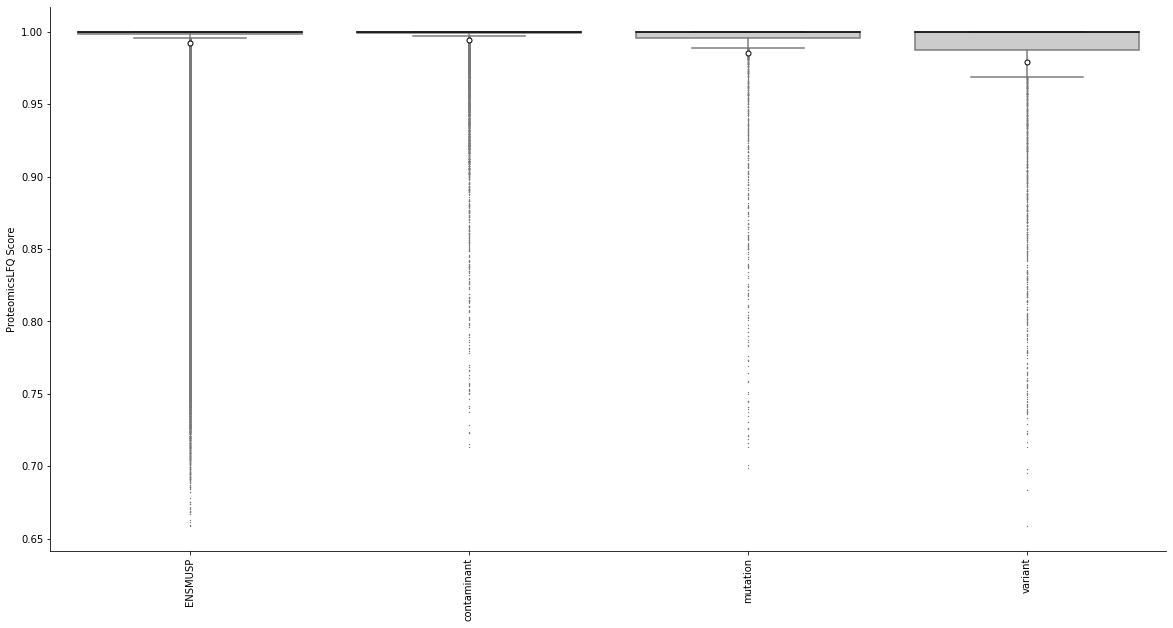

In [59]:
plt.clf()
plt.figure()
fig = sns.boxplot(x = 'Class', y= 'searchScore', data = psms, 
                  flierprops=flierprops, color=".8", 
                  showmeans=True, 
                  meanprops={"marker":"o", "markerfacecolor":"white", 
                             "markeredgecolor":"black", "markersize":"5"},
                 medianprops=dict(color="black", alpha=1.0))
#fig = sns.violinplot(x="Class", y="searchScore", data=psms, inner=None, color=".8")
#fig = sns.swarmplot(x="Class", y="searchScore", data=psms, color=".25")
#fig = sns.stripplot(x = 'Class', y= 'searchScore', hue='0.9', data = psms, jitter=0.05)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set_xlabel('')
fig.set_ylabel('ProteomicsLFQ Score')
sns.despine(right=True)
fig.grid(False)
plt.savefig('class_mice.svg', bbox_inches='tight')
plt.savefig('class_mice.pdf', bbox_inches='tight')

<Figure size 1440x720 with 0 Axes>

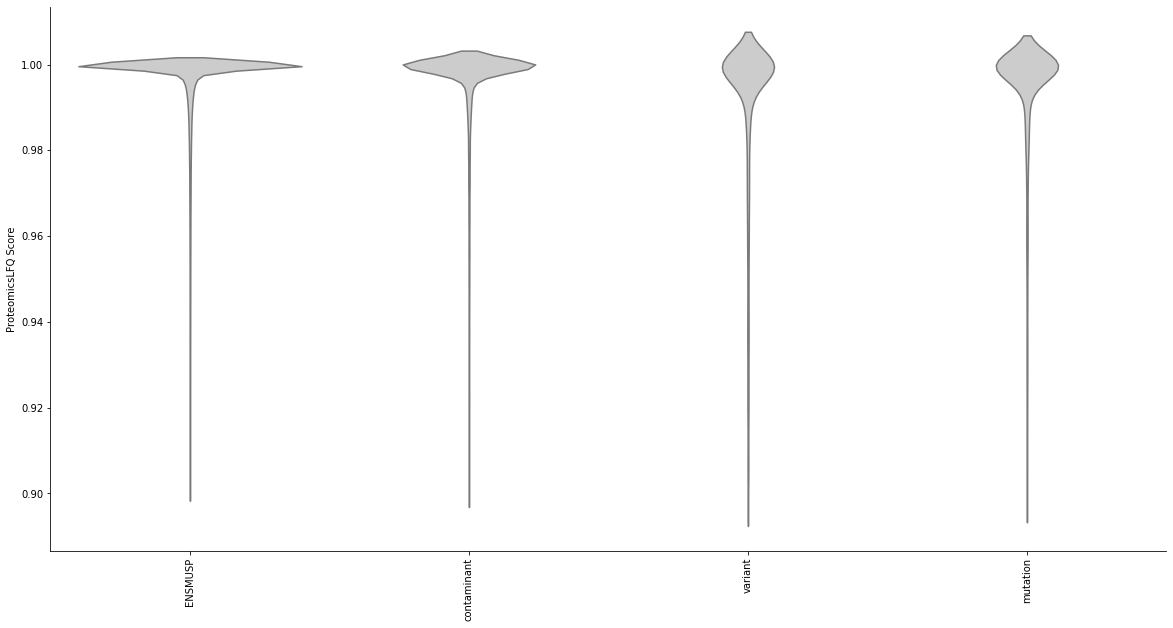

In [60]:
plt.clf()
plt.figure()
fig = sns.violinplot(x="Class", y="searchScore", data=psms[psms['searchScore']>=0.9], inner=None, color=".8")
#fig = sns.boxplot(x = 'Class', y= 'searchScore', data = psms[psms['searchScore']>=0.9], flierprops=flierprops, medianprops=dict(color="white", alpha=0.7))
#fig = sns.swarmplot(x = "Class", y = "searchScore", data = psms, color = ".25")
fig.set_xlabel('')
fig.set_ylabel('ProteomicsLFQ Score')
sns.despine(right=True)
fig.grid(False)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.savefig('class_mice_0.9-1_violin.svg', bbox_inches='tight')
plt.savefig('class_mice_0.9-1_violin.pdf', bbox_inches='tight')

<Figure size 1440x720 with 0 Axes>

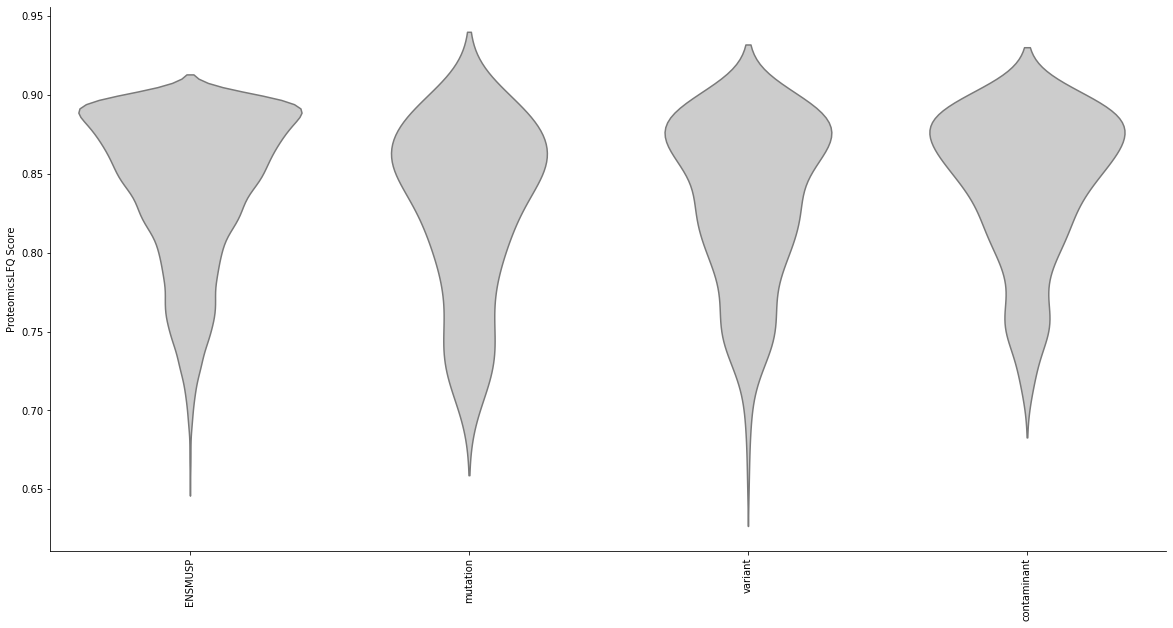

In [61]:
plt.clf()
plt.figure()
fig = sns.violinplot(x="Class", y="searchScore", data=psms[psms['searchScore']<0.9], inner=None, color=".8")
fig.set_xlabel('')
fig.set_ylabel('ProteomicsLFQ Score')
sns.despine(right=True)
fig.grid(False)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.savefig('class_mice_0.1-0.9_violin.svg', bbox_inches='tight')
plt.savefig('class_mice_0.1-0.9_violin.pdf', bbox_inches='tight')